In [45]:
#import the libraries 
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt



This is formatted as code The MNIST dataset will be used for training the autoencoder. This dataset contains thousands of 28 x 28 pixel images of handwritten digits. As such, our autoencoder will learn the distribution of handwritten digits across (two)dimensional latent space, which we can then use to manipulate samples into a format we like.

In [46]:
# Load MNIST dataset
(input_train_1, target_train_1), (input_test_1, target_test_1) = mnist.load_data()

Check the data shape and reduce if neccessary 

In [47]:
print(input_train_1.shape)
print(input_test_1.shape)
print(target_train_1.shape)
print(target_test_1.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Since original data size was throwing out of memory error and required more GPU, I reduced the data size here (Training set is reduced from 60000 to 10000, and test set is reduced from 10000 to 1000 images.

In [48]:
input_train=input_train_1[0:10000]
target_train=target_train_1[0:10000]
input_test=input_test_1[0:1000]
target_test=target_test_1[0:1000]

Print the first 10 images in training set

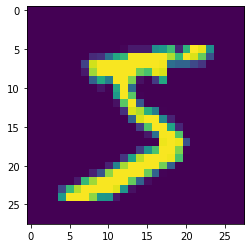

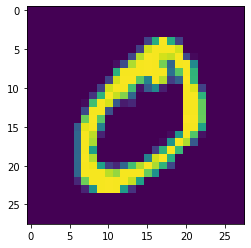

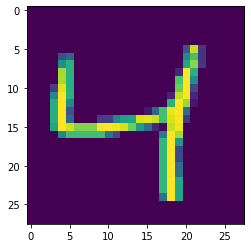

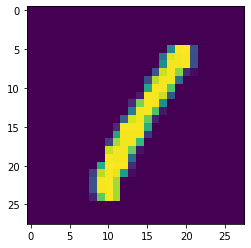

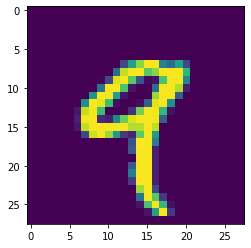

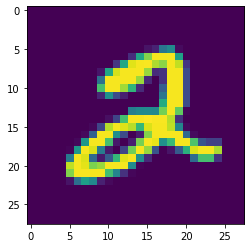

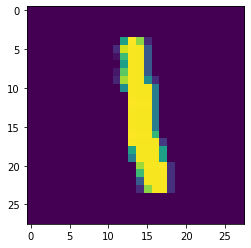

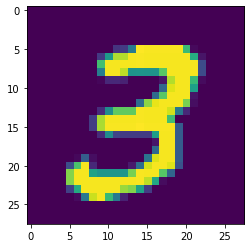

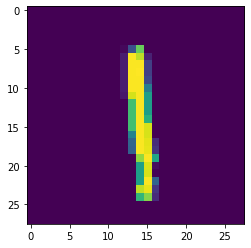

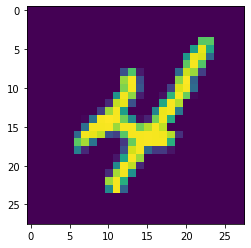

In [49]:
for i in range(10):
  pr_image = input_train[i]
  pr_image = np.array(pr_image, dtype='float')
  pixels = pr_image.reshape((28, 28))
  plt.imshow(pixels)
  plt.show()

Check the size of reduced data set

In [50]:
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(10000, 28, 28)
(1000, 28, 28)
(10000,)
(1000,)


Model configuration: 
 Setting config parameters for data and model.

 The width and height of our configuration settings is determined by the training data. In our case, they will be img_width = img_height = 28, as the MNIST dataset contains samples that are 28 x 28 pixels.

Batch size is set to 128 samples per (mini)batch, which is quite normal. The same is true for the number of epochs, which was set to 50. 20% of the training data is used for validation purposes. This is also quite normal. Nothing special here.

Verbosity mode is set to True (by means of 1), which means that all the output is shown on screen.

The final two configuration settings are of relatively more interest. First, the latent space will be two-dimensional . Finally, the num_channels parameter can be configured to equal the number of image channels: for RGB data, it’s 3 (red – green – blue), and for grayscale data (such as MNIST), it’s 1

In [51]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.5
verbosity = 1
latent_dim = 2
num_channels = 1

Next, we reshape the data so that it takes the shape (X, 28, 28, 1), where X is the number of samples in either the training or testing dataset. We also set (28, 28, 1) as input_shape.

Next, we parse the numbers as floats, which presumably speeds up the training process, and normalize it, which the neural network appreciates

In [52]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

Creating the encoder

Now, it’s time to create the encoder. This is a three-step process: firstly, we define it. Secondly, we perform something that is known as the reparameterization trick in order to allow us to link the encoder to the decoder later, to instantiate the VAE as a whole. But before that, we instantiate the encoder first, as our third and final step.

Encoder definition

The first step in the three-step process is the definition of our encoder. Following the connection process of the Keras Functional API, we link the layers together:

In [53]:
# Encoder Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
          # New 2 layer: I added Conv2D with 32 filters and BatchNormalization to help coordinate the update of multiple layers in the model.
cx      = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

Let’s now take a look at the individual lines of code in more detail.

The first layer is the Input layer. It accepts data with input_shape = (28, 28, 1) and is named encoder_input. 

Next up is a two-dimensional convolutional layer, or Conv2D in Keras terms. It learns 8 filters by deploying a 3 x 3 kernel which it convolves over the input. It has a stride of two which means that it skips over the input during the convolution as well, speeding up the learning process. It employs ‘same’ padding and ReLU activation. Do note that officially, it’s best to use He init with ReLU activating layers. However, since the dataset is relatively small, it shouldn’t be too much of a problem if you don’t.

Subsequently, we use Batch Normalization. This layer ensures that the outputs of the Conv2D layer that are input to the next Conv2D layer have a steady mean and variance, likely μ=0.0,σ=1.0 (plus some ϵ, an error term to ensure numerical stability). This benefits the learning process.

Once again, a Conv2D layer. It learns 16 filters and for the rest is equal to the first Conv2D layer.

BatchNormalization once more.

Next up, a Flatten layer, it only serves to flatten the multidimensional data from the convolutional layers into one-dimensional shape. This has to be done because the densely-connected layers that we use next require data to have this shape.

The next layer is a Dense layer with 20 output neurons. It’s the autoencoder bottleneck we’ve been talking about.

BatchNormalization once more.

The next two layers, mu and sigma, are actually not separate from each other – look at the previous layer they are linked to (both x, i.e. the Dense(20) layer). The first outputs the mean values μ of the encoded input and the second one outputs the stddevs σ. With these, we can sample the random variables that constitute the point in latent space onto which some input is mapped.
That’s for the layers of our encoder.

 The next step is to retrieve the shape of the final Conv2D output. We’ll need it when defining the layers of our decoder

In [54]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [55]:
conv_shape[1]

7

I’ll try to explain the need for reparameritization briefly:

If you use neural networks (or, to be more precise, gradient descent) for optimizing the variational autoencoder, you effectively minimize some expected loss value, which can be estimated with Monte-Carlo techniques (Huang, n.d.). However, this requires that the loss function is differentiable, which is not necessarily the case, because it is dependent on the parameter of some probability distribution that we don’t know about. In this case, it’s possible to rewrite the equation, but then it no longer has the form of an expectation, making it impossible to use the Monte-Carlo techniques usable before.

However, if we can reparameterize the sample fed to the function into the shape μ+σ2×ϵ, it now becomes possible to use gradient descent for estimating the gradients accurately (Gunderson, n.d.; Huang, n.d.).

And that’s precisely what we’ll do in our code. We “sample” the value for z from the computed μ and σ values by resampling into mu + K.exp(sigma / 2) * eps.

In [56]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

We then use this with a Lambda to ensure that correct gradients are computed during the backwards pass based on our values for mu and sigma:

In [57]:
# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

Encoder instantiation:

Now, it’s time to instantiate the encoder – taking inputs through input layer i, and outputting the values generated by the mu, sigma and z layers (i.e., the individual means and standard deviations, and the point sampled from the random variable represented by them):

In [58]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 14, 14, 8)    32          conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_16[0][0]     
____________________________________________________________________________________________

Creating the decoder

Creating the decoder is a bit simpler and boils down to a two-step process: defining it, and instantiating it.

In [59]:
# Decoder Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
      # I start the decoder with the one that I have added in the encoder.
cx    = Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

Our decoder also starts with an Input layer, the decoder_input layer. It takes input with the shape (latent_dim, ), which as we will see is the vector we sampled for z with our encoder.

If we’d like to upsample the point in latent space with Conv2DTranspose layers, in exactly the opposite symmetrical order as with we downsampled with our encoder, we must first bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last convolutional layer of our encoder.

This is why you needed the conv_shape variable. We’ll thus now add a Dense layer which has conv_shape[1] * conv_shape[2] * conv_shape[3] output, and converts the latent space into many outputs.

We next use a Reshape layer to convert the output of the Dense layer into the output shape of the last convolutional layer: (conv_shape[1], conv_shape[2], conv_shape[3] = (7, 7, 16). Sixteen filters learnt with 7 x 7 pixels per filter.

We then use Conv2DTranspose and BatchNormalization in the exact opposite order as with our encoder to upsample our data into 28 x 28 pixels (which is equal to the width and height of our inputs). However, we still have 8 filters, so the shape so far is (28, 28, 8).

We therefore add a final Conv2DTranspose layer which does nothing to the width and height of the data, but ensures that the number of filters learns equals num_channels. For MNIST data, where num_channels = 1, this means that the shape of our output will be (28, 28, 1). This last layer also uses Sigmoid activation, which allows us to use binary crossentropy loss when computing the reconstruction loss part of our loss function.

Decoder instantiation

The next thing we do is instantiate the decoder:

It takes the inputs from the decoder input layer d_i and outputs whatever is output by the output layer o.

In [60]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1568)              4704      
_________________________________________________________________
batch_normalization_20 (Batc (None, 1568)              6272      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 32)          9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 16)        4624

Creating the whole VAE

Now that the encoder and decoder are complete, we can create the VAE as a whole.

If you think about it, the outputs of the entire VAE are the original inputs, encoded by the encoder, and decoded by the decoder.

That’s how we arrive at vae_outputs = decoder(encoder(i)[2]): inputs i are encoded by the encoder into [mu, sigma, z] (the individual means and standard deviations with the sampled z as well). We then take the sampled z values (hence the [2]) and feed it to the decoder, which ensures that we arrive at correct VAE output.

We then instantiate the model: i are our inputs indeed, and vae_outputs are the outputs. We call the model vae, because it simply is Variational Auto Encoder.

In [61]:
# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 37656     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         26305     
Total params: 63,961
Trainable params: 60,561
Non-trainable params: 3,400
_________________________________________________________________


Compilation & training:

we can compile our model. We do so using the Adam optimizer and binary crossentropy loss function.

tf.config.run_functions_eagerly(True) is added to overcome the vae.fit error with colab, you may not need it if you are running the code in pycharm or jupyter notebooks.

In [62]:
tf.config.run_functions_eagerly(True)
# Compile VAE
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Epoch 1/50
 1/40 [..............................] - ETA: 5s - loss: 0.8486

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


40/40 [==============================] - 4s 96ms/step - loss: 0.6853 - val_loss: 0.6240
Epoch 2/50
40/40 [==============================] - 4s 101ms/step - loss: 0.5330 - val_loss: 0.4801
Epoch 3/50
40/40 [==============================] - 4s 93ms/step - loss: 0.3640 - val_loss: 0.3789
Epoch 4/50
40/40 [==============================] - 4s 91ms/step - loss: 0.2776 - val_loss: 0.3509
Epoch 5/50
40/40 [==============================] - 4s 99ms/step - loss: 0.2449 - val_loss: 0.3405
Epoch 6/50
40/40 [==============================] - 3s 88ms/step - loss: 0.2323 - val_loss: 0.3275
Epoch 7/50
40/40 [==============================] - 4s 99ms/step - loss: 0.2243 - val_loss: 0.3077
Epoch 8/50
40/40 [==============================] - 4s 99ms/step - loss: 0.2193 - val_loss: 0.2897
Epoch 9/50
40/40 [==============================] - 4s 100ms/step - loss: 0.2164 - val_loss: 0.2639
Epoch 10/50
40/40 [==============================] - 4s 99ms/step - loss: 0.2135 - val_loss: 0.2455
Epoch 11/50
40/40 

In [63]:
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/


def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

In [64]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


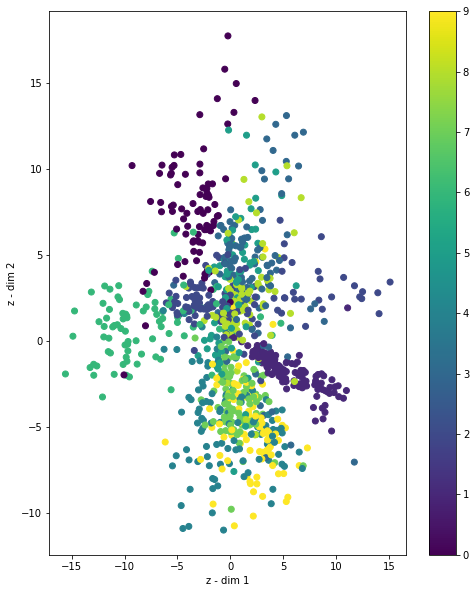

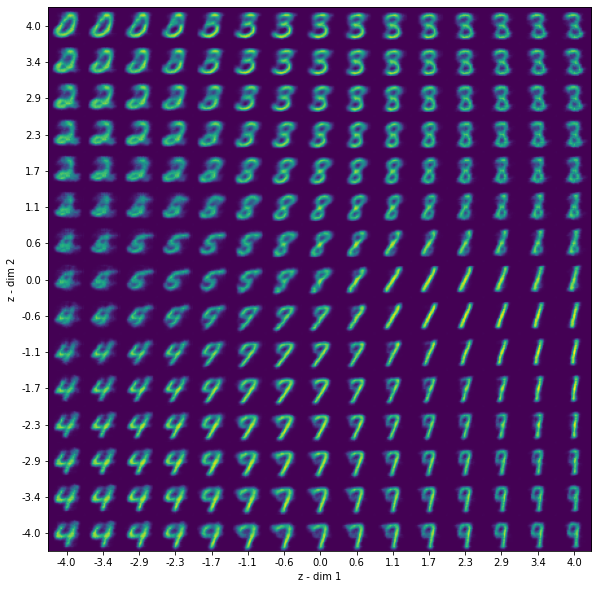

In [65]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)